# ECRQ Tables and Graphs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.iolib.summary2 import summary_col
from scipy import stats

In [2]:
# Read only total_tract_population column from acs_data.csv
density_pop = pd.read_csv(
    "../data/acs_data_all.csv",
    usecols=["tract", "density"],
    dtype={"density": np.float32, "tract": np.int32},
)
density_pop.columns

Index(['tract', 'density'], dtype='object')

In [3]:
# Load the data
dtype_dict = {
    "white_adj_supply_any_avg_tract": np.float32,
    "white_adj_supply_hr_avg_tract": np.float32,
    "white_totcost_any_avg_tract": np.float32,
    "black_adj_supply_any_avg_tract": np.float32,
    "black_adj_supply_hr_avg_tract": np.float32,
    "black_totcost_any_avg_tract": np.float32,
    "am_indian_alaska_native_adj_supply_any_avg_tract": np.float32,
    "am_indian_alaska_native_adj_supply_hr_avg_tract": np.float32,
    "am_indian_alaska_native_totcost_any_avg_tract": np.float32,
    "asian_supply_adj_supply_any_tract": np.float32,
    "asian_adj_supply_hr_avg_tract": np.float32,
    "asian_totcost_any_avg_tract": np.float32,
    "other_race_adj_supply_any_avg_tract": np.float32,
    "other_race_adj_supply_hr_avg_tract": np.float32,
    "other_race_totcost_any_avg_tract": np.float32,
    "hispanic_latino_adj_supply_any_avg_tract": np.float32,
    "hispanic_latino_adj_supply_hr_avg_tract": np.float32,
    "hispanic_latino_totcost_any_avg_tract": np.float32,
    "state": np.int32,
    "county": np.int32,
    "tract": np.int32,
    "median_household_income": np.float32,
    "gini_index": np.float32,
    "educational_attainment": np.float32,
    "employment_status": np.float32,
    "housing_tenure": np.float32,
    "poverty_status": np.float32,
    "commute_time": np.float32,
    "without_health_insurance": np.float32,
    "labor_force_status": np.float32,
    "total_population_25_years_and_over": np.float32,
    "white": np.float32,
    "black": np.float32,
    "am_indian_alaska_native": np.float32,
    "asian": np.float32,
    "native_hawaiian_pacific_islander": np.float32,
    "other_race": np.float32,
    "two_or_more_races": np.float32,
    "hispanic_latino": np.float32,
    "total_tract_population": np.int32,
}


data = pd.read_csv(
    "../data/acs_data.csv", dtype=dtype_dict
)  # Replace with the path to your data file

# Merge density_pop to data
data = data.merge(density_pop, how="left", on="tract", validate="1:1")

# Scale median_household_income by 10,000
data["median_household_income"] = data["median_household_income"] / 10000

# Scale density by 10,000
data["density"] = data["density"] / 10000

# Rename the variables
data.rename(
    columns={
        "white_adj_supply_any_avg_tract": "White any",
        "white_adj_supply_hr_avg_tract": "White high rated",
        "white_totcost_any_avg_tract": "White total cost",
        "black_adj_supply_any_avg_tract": "Black any",
        "black_adj_supply_hr_avg_tract": "Black high rated",
        "black_totcost_any_avg_tract": "Black total cost",
        "am_indian_alaska_native_adj_supply_any_avg_tract": "American Indian Alaska Native any",
        "am_indian_alaska_native_adj_supply_hr_avg_tract": "American Indian Alaska Native high rated",
        "am_indian_alaska_native_totcost_any_avg_tract": "American Indian Alaska Native total cost",
        "asian_adj_supply_any_avg_tract": "Asian any",
        "asian_adj_supply_hr_avg_tract": "Asian high rated",
        "asian_totcost_any_avg_tract": "Asian total cost",
        "other_race_adj_supply_any_avg_tract": "Other race any",
        "other_race_adj_supply_hr_avg_tract": "Other race high rated",
        "other_race_totcost_any_avg_tract": "Other race total cost",
        "hispanic_latino_adj_supply_any_avg_tract": "Hispanic Latino any",
        "hispanic_latino_adj_supply_hr_avg_tract": "Hispanic Latino high rated",
        "hispanic_latino_totcost_any_avg_tract": "Hispanic Latino total cost",
        "median_household_income": "Median Household Income",
        "gini_index": "Gini Index",
        "educational_attainment": "Educational Attainment",
        "employment_status": "Employment Status",
        "housing_tenure": "Housing Tenure",
        "poverty_status": "Poverty Status",
        "commute_time": "Commute Time",
        "without_health_insurance": "Without Health Insurance",
        "labor_force_status": "Labor Force Status",
        "total_population_25_years_and_over": "Total Population 25 Years and Over",
        "density": "Population Density",
    },
    inplace=True,
)

# calculate state population
state_population = data.groupby("state")["total_tract_population"].transform("sum")

# create tract_weight
data["tract_weight"] = data["total_tract_population"] / state_population

In [4]:
data.head()

,White any,White high rated,White total cost,Black any,Black high rated,Black total cost,American Indian Alaska Native any,American Indian Alaska Native high rated,American Indian Alaska Native total cost,Asian any,...,black,am_indian_alaska_native,asian,native_hawaiian_pacific_islander,other_race,two_or_more_races,hispanic_latino,total_tract_population,Population Density,tract_weight
0,0.027303,0.007869,141.404892,0.040353,0.011630,145.017502,0.000002,5.932382e-14,135.126480,6.304092e-07,...,0.000042,0.000741,0.000063,0.000000,0.000308,0.000133,0.000150,2240,0.000218,0.000404
1,0.229566,0.000000,48.881134,0.668083,0.000000,39.188812,0.097253,0.000000e+00,82.443626,6.680830e-01,...,0.000020,0.001586,0.000004,0.001367,0.000048,0.000732,0.000067,2284,0.000226,0.000411
2,0.463983,0.078133,147.899124,0.341689,0.050960,150.966522,0.301611,3.909673e-02,151.896408,4.202191e-01,...,0.000079,0.000672,0.000048,0.000000,0.000019,0.000514,0.000240,3483,0.004462,0.000627
3,0.413980,0.027758,71.953590,0.568615,0.042709,52.525444,0.921216,7.764238e-02,57.557652,0.000000e+00,...,0.000070,0.002534,0.000000,0.000000,0.000019,0.000375,0.000134,2970,0.000295,0.000535
4,0.012008,0.000000,72.200478,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000011,0.000000,0.000052,0.000000,0.000000,0.000085,0.000033,1905,0.000295,0.000343


## Summary Statistics

In [5]:
variables = {
    "White any": "white",
    "White high rated": "white",
    "White total cost": "white",
    "Black any": "black",
    "Black high rated": "black",
    "Black total cost": "black",
    "American Indian Alaska Native any": "am_indian_alaska_native",
    "American Indian Alaska Native high rated": "am_indian_alaska_native",
    "American Indian Alaska Native total cost": "am_indian_alaska_native",
    "Asian any": "asian",
    "Asian high rated": "asian",
    "Asian total cost": "asian",
    "Other race any": "other_race",
    "Other race high rated": "other_race",
    "Other race total cost": "other_race",
    "Hispanic Latino any": "hispanic_latino",
    "Hispanic Latino high rated": "hispanic_latino",
    "Hispanic Latino total cost": "hispanic_latino",
    "Median Household Income": "median_household_income",
    "Gini Index": "gini_index",
    "Educational Attainment": "educational_attainment",
    "Employment Status": "employment_status",
    "Housing Tenure": "housing_tenure",
    "Poverty Status": "poverty_status",
    "Commute Time": "commute_time",
    "Without Health Insurance": "without_health_insurance",
    "Population Density": "density",
}

racial_groups = list(variables.keys())[:18]
racial_weights = list(variables.values())[:18]
other_covariates = list(variables.keys())[18:]

summary_statistics = {}

# Calculate weighted averages and standard deviations for racial groups
for group, weight in zip(racial_groups, racial_weights):
    weighted_mean = (data[group] * data[weight]).sum()
    weighted_std = np.sqrt((data[weight] * (data[group] - weighted_mean) ** 2).sum())
    summary_statistics[group] = {"mean": weighted_mean, "std": weighted_std}

# Calculate weighted averages and standard deviations for other covariates using 'tract_weight' as weight
for covariate in other_covariates:
    weighted_mean = (data[covariate] * data["tract_weight"]).sum() / data[
        "tract_weight"
    ].sum()
    weighted_std = np.sqrt(
        (data["tract_weight"] * (data[covariate] - weighted_mean) ** 2).sum()
        / data["tract_weight"].sum()
    )
    summary_statistics[covariate] = {"mean": weighted_mean, "std": weighted_std}

# Convert the dictionary to a DataFrame
summary_statistics_df = pd.DataFrame(summary_statistics).T

# Format the summary statistics table
summary_statistics_df = summary_statistics_df.applymap("{:.2f}".format)
summary_statistics_df["std"] = "(" + summary_statistics_df["std"] + ")"
summary_statistics_df.rename(
    columns={"mean": "Mean", "std": "Std Deviation"}, inplace=True
)

print(summary_statistics_df)

                                            Mean Std Deviation
White any                                   0.57        (0.28)
White high rated                            0.13        (0.12)
White total cost                          179.35       (67.40)
Black any                                   0.59        (0.24)
Black high rated                            0.20        (0.11)
Black total cost                          214.47       (52.29)
American Indian Alaska Native any           0.59        (0.37)
American Indian Alaska Native high rated    0.12        (0.14)
American Indian Alaska Native total cost  135.05       (74.13)
Asian any                                   0.54        (0.24)
Asian high rated                            0.18        (0.10)
Asian total cost                          215.61       (59.33)
Other race any                              0.59        (0.27)
Other race high rated                       0.17        (0.12)
Other race total cost                     197.89       

## CDF Plots

In [6]:
def weighted_percentile(data, weights, percentile):
    """
    Calculate the weighted percentile of a 1D numpy array.
    """
    # Sort the data
    idx_sorted = np.argsort(data)
    sorted_data = data[idx_sorted]
    sorted_weights = weights[idx_sorted]

    # Calculate the cumulative sum of weights
    sn = np.cumsum(sorted_weights)

    # Calculate the percentile
    p = percentile / 100.0
    target = p * np.sum(weights)
    return np.interp(target, sn, sorted_data)

In [7]:
def calculate_percentiles(data, race_variables, weight_map):
    # Initialize an empty DataFrame to store the percentiles
    percentiles = pd.DataFrame()

    # Calculate the percentiles for each group
    for var in race_variables:
        # Get the weights for this variable
        weights = data[weight_map[var]]

        # Calculate the weighted percentiles
        percentiles[var] = [
            weighted_percentile(data[var].values, weights.values, i)
            for i in range(5, 100, 5)
        ]

    # Transpose the DataFrame for a better layout
    percentiles = percentiles.transpose()

    # Rename the index and columns for clarity
    percentiles.index.name = "Race"
    percentiles.columns = [f"{i}th Percentile" for i in range(5, 100, 5)]

    return percentiles

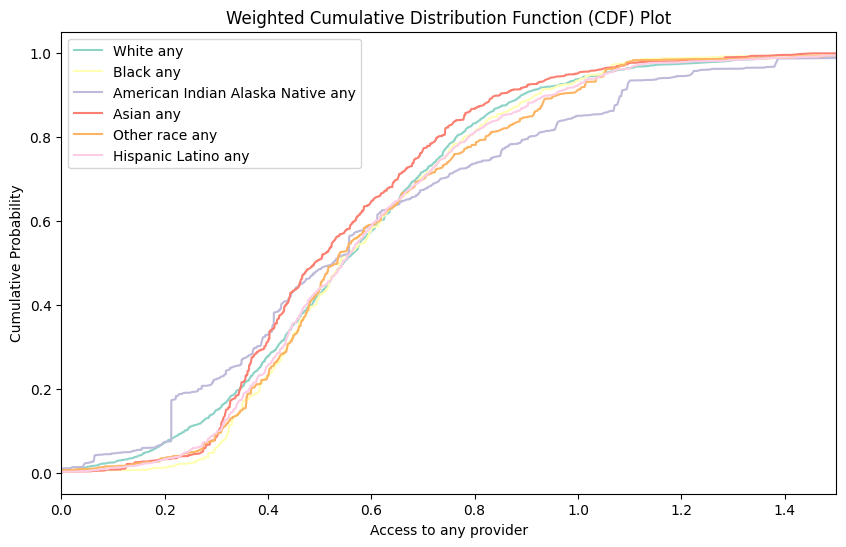

In [8]:
# CDF plot
race_variables1 = [
    "White any",
    "Black any",
    "American Indian Alaska Native any",
    "Asian any",
    "Other race any",
    "Hispanic Latino any",
]

colors = ["#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#fdb462", "#fccde5"]

weight_map1 = {
    "White any": "white",
    "Black any": "black",
    "American Indian Alaska Native any": "am_indian_alaska_native",
    "Asian any": "asian",
    "Other race any": "other_race",
    "Hispanic Latino any": "hispanic_latino",
}


fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables1, colors):
    # Get the weights for this variable
    weights = data[weight_map1[var]]

    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))

    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)

    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]

    ax.plot(values, cumulative, label=var, color=color)

ax.set_title("Weighted Cumulative Distribution Function (CDF) Plot")
ax.set_xlabel("Access to any provider")
ax.set_ylabel("Cumulative Probability")
ax.legend(loc="upper left")

# Set x-axis limit
ax.set_xlim(0, 1.5)

plt.show()

In [9]:
percentiles1 = calculate_percentiles(data, race_variables1, weight_map1)
print(percentiles1)

                                   5th Percentile  10th Percentile  \
Race                                                                 
White any                                0.169457         0.238974   
Black any                                0.295952         0.323885   
American Indian Alaska Native any        0.135628         0.212852   
Asian any                                0.273563         0.304989   
Other race any                           0.259702         0.310141   
Hispanic Latino any                      0.245376         0.306339   

                                   15th Percentile  20th Percentile  \
Race                                                                  
White any                                 0.302678         0.345589   
Black any                                 0.348441         0.383215   
American Indian Alaska Native any         0.212921         0.271812   
Asian any                                 0.319627         0.346783   
Other race an

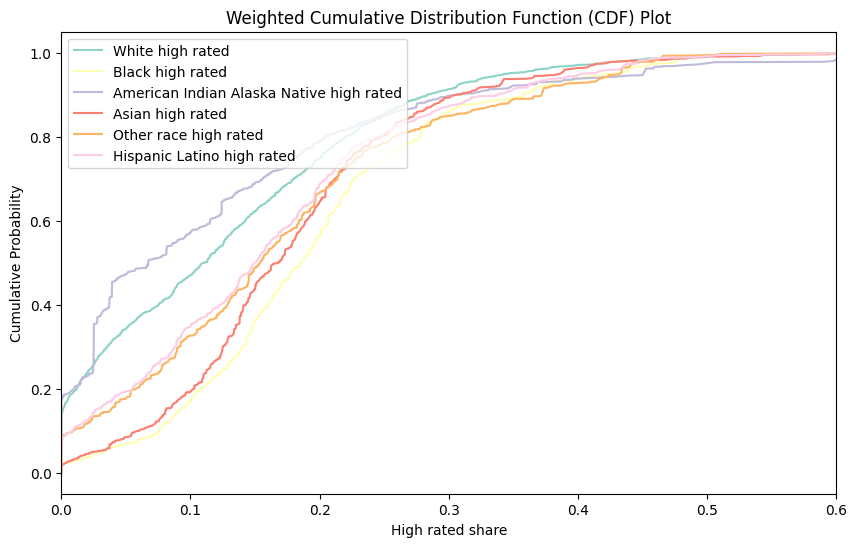

In [10]:
# CDF plot
race_variables2 = [
    "White high rated",
    "Black high rated",
    "American Indian Alaska Native high rated",
    "Asian high rated",
    "Other race high rated",
    "Hispanic Latino high rated",
]

colors = ["#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#fdb462", "#fccde5"]

weight_map2 = {
    "White high rated": "white",
    "Black high rated": "black",
    "American Indian Alaska Native high rated": "am_indian_alaska_native",
    "Asian high rated": "asian",
    "Other race high rated": "other_race",
    "Hispanic Latino high rated": "hispanic_latino",
}


fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables2, colors):
    # Get the weights for this variable
    weights = data[weight_map2[var]]

    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))

    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)

    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]

    ax.plot(values, cumulative, label=var, color=color)

ax.set_title("Weighted Cumulative Distribution Function (CDF) Plot")
ax.set_xlabel("High rated share")
ax.set_ylabel("Cumulative Probability")
ax.legend(loc="upper left")

# Set x-axis limit
ax.set_xlim(0, 0.6)

plt.show()

In [11]:
percentiles2 = calculate_percentiles(data, race_variables2, weight_map2)
print(percentiles2)

                                          5th Percentile  10th Percentile  \
Race                                                                        
White high rated                            0.000000e+00     7.073740e-09   
Black high rated                            3.190943e-02     7.552631e-02   
American Indian Alaska Native high rated    0.000000e+00     0.000000e+00   
Asian high rated                            2.516231e-02     6.017847e-02   
Other race high rated                       1.963632e-14     9.074796e-03   
Hispanic Latino high rated                  2.204224e-13     8.508451e-03   

                                          15th Percentile  20th Percentile  \
Race                                                                         
White high rated                                 0.001344         0.011698   
Black high rated                                 0.091956         0.107775   
American Indian Alaska Native high rated         0.000002         0.009

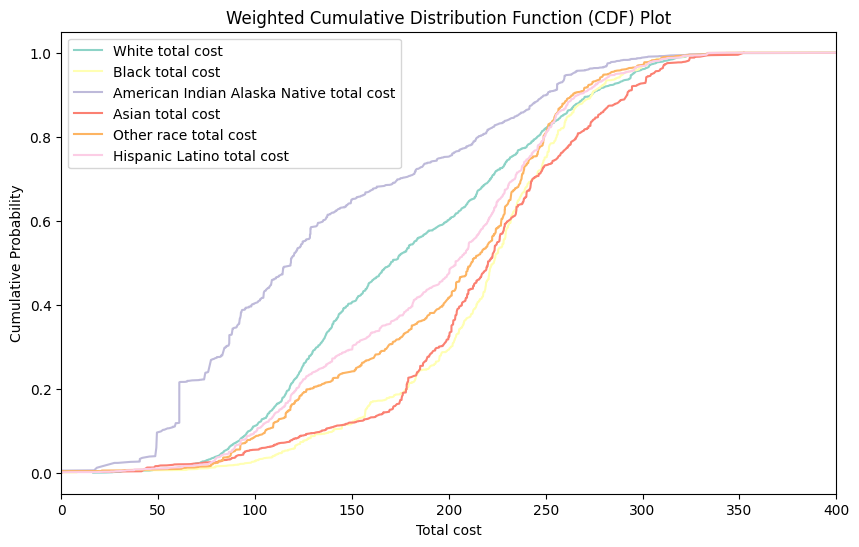

In [12]:
# CDF plot
race_variables3 = [
    "White total cost",
    "Black total cost",
    "American Indian Alaska Native total cost",
    "Asian total cost",
    "Other race total cost",
    "Hispanic Latino total cost",
]

colors = ["#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#fdb462", "#fccde5"]

weight_map3 = {
    "White total cost": "white",
    "Black total cost": "black",
    "American Indian Alaska Native total cost": "am_indian_alaska_native",
    "Asian total cost": "asian",
    "Other race total cost": "other_race",
    "Hispanic Latino total cost": "hispanic_latino",
}


fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables3, colors):
    # Get the weights for this variable
    weights = data[weight_map3[var]]

    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))

    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)

    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]

    ax.plot(values, cumulative, label=var, color=color)

ax.set_title("Weighted Cumulative Distribution Function (CDF) Plot")
ax.set_xlabel("Total cost")
ax.set_ylabel("Cumulative Probability")
ax.legend(loc="upper left")

# Set x-axis limit
ax.set_xlim(0, 400)

plt.show()

In [13]:
percentiles3 = calculate_percentiles(data, race_variables3, weight_map3)
print(percentiles3)

                                          5th Percentile  10th Percentile  \
Race                                                                        
White total cost                               83.854292        97.375722   
Black total cost                              114.114008       140.587822   
American Indian Alaska Native total cost       48.794239        51.915740   
Asian total cost                               94.752696       134.344946   
Other race total cost                          88.677930       105.383451   
Hispanic Latino total cost                     87.702676       100.844787   

                                          15th Percentile  20th Percentile  \
Race                                                                         
White total cost                               108.894727       117.690073   
Black total cost                               157.151057       178.498733   
American Indian Alaska Native total cost        60.909518        60.916

## Matrix of Differences

In [14]:
# Create an empty dataframe for the significance
significance_matrix1 = pd.DataFrame(index=race_variables1, columns=race_variables1)
# Create an empty dataframe for the matrix
matrix1 = pd.DataFrame(index=race_variables1, columns=race_variables1)

def weighted_sample(series, weights):
    # Repeat elements according to the weights
    return np.repeat(series, weights)

for row_var in race_variables1:
    for col_var in race_variables1:
        if row_var != col_var:
            row_weighted_sample = weighted_sample(data[row_var], data[weight_map1[row_var]])
            col_weighted_sample = weighted_sample(data[col_var], data[weight_map1[col_var]])

            # Perform a t-test
            t_stat, p_value = stats.ttest_ind(row_weighted_sample, col_weighted_sample)

            # Calculate the weighted means
            row_weighted_mean = (
                data[row_var] * data[weight_map1[row_var]]
            ).sum() / data[weight_map1[row_var]].sum()
            col_weighted_mean = (
                data[col_var] * data[weight_map1[col_var]]
            ).sum() / data[weight_map1[col_var]].sum()

            # Store the difference and significance
            matrix1.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean
            significance_matrix1.loc[row_var, col_var] = '*' if p_value < 0.05 else ''

In [15]:
matrix1

,White any,Black any,American Indian Alaska Native any,Asian any,Other race any,Hispanic Latino any
White any,NaN,-0.018817,-0.021563,0.026921,-0.022033,-0.015735
Black any,0.018817,NaN,-0.002746,0.045738,-0.003216,0.003082
American Indian Alaska Native any,0.021563,0.002746,NaN,0.048484,-0.00047,0.005828
Asian any,-0.026921,-0.045738,-0.048484,NaN,-0.048954,-0.042656
Other race any,0.022033,0.003216,0.00047,0.048954,NaN,0.006298
Hispanic Latino any,0.015735,-0.003082,-0.005828,0.042656,-0.006298,NaN


In [16]:
significance_matrix1

,White any,Black any,American Indian Alaska Native any,Asian any,Other race any,Hispanic Latino any
White any,NaN,,,,,
Black any,,NaN,,,,
American Indian Alaska Native any,,,NaN,,,
Asian any,,,,NaN,,
Other race any,,,,,NaN,
Hispanic Latino any,,,,,,NaN


In [17]:
# Matrix of differences
# Create an empty dataframe for the matrix
matrix1 = pd.DataFrame(index=race_variables1, columns=race_variables1)

# Calculate the weighted average difference for each pair of variables
for row_var in race_variables1:
    for col_var in race_variables1:
        if row_var != col_var:
            row_weighted_mean = (
                data[row_var] * data[weight_map1[row_var]]
            ).sum() / data[weight_map1[row_var]].sum()
            col_weighted_mean = (
                data[col_var] * data[weight_map1[col_var]]
            ).sum() / data[weight_map1[col_var]].sum()
            matrix1.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean

In [18]:
matrix1

,White any,Black any,American Indian Alaska Native any,Asian any,Other race any,Hispanic Latino any
White any,NaN,-0.018817,-0.021563,0.026921,-0.022033,-0.015735
Black any,0.018817,NaN,-0.002746,0.045738,-0.003216,0.003082
American Indian Alaska Native any,0.021563,0.002746,NaN,0.048484,-0.00047,0.005828
Asian any,-0.026921,-0.045738,-0.048484,NaN,-0.048954,-0.042656
Other race any,0.022033,0.003216,0.00047,0.048954,NaN,0.006298
Hispanic Latino any,0.015735,-0.003082,-0.005828,0.042656,-0.006298,NaN


In [19]:
# Create an empty dataframe for the significance
significance_matrix2 = pd.DataFrame(index=race_variables2, columns=race_variables2)
# Create an empty dataframe for the matrix
matrix2 = pd.DataFrame(index=race_variables2, columns=race_variables2)

for row_var in race_variables2:
    for col_var in race_variables2:
        if row_var != col_var:
            row_weighted_sample = weighted_sample(data[row_var], data[weight_map2[row_var]])
            col_weighted_sample = weighted_sample(data[col_var], data[weight_map2[col_var]])

            # Perform a t-test
            t_stat, p_value = stats.ttest_ind(row_weighted_sample, col_weighted_sample)

            # Calculate the weighted means
            row_weighted_mean = (
                data[row_var] * data[weight_map2[row_var]]
            ).sum() / data[weight_map2[row_var]].sum()
            col_weighted_mean = (
                data[col_var] * data[weight_map2[col_var]]
            ).sum() / data[weight_map2[col_var]].sum()

            # Store the difference and significance
            matrix2.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean
            significance_matrix2.loc[row_var, col_var] = '*' if p_value < 0.05 else ''

In [20]:
matrix2

,White high rated,Black high rated,American Indian Alaska Native high rated,Asian high rated,Other race high rated,Hispanic Latino high rated
White high rated,NaN,-0.068578,0.007972,-0.050509,-0.041752,-0.033263
Black high rated,0.068578,NaN,0.07655,0.018069,0.026825,0.035314
American Indian Alaska Native high rated,-0.007972,-0.07655,NaN,-0.058481,-0.049724,-0.041235
Asian high rated,0.050509,-0.018069,0.058481,NaN,0.008756,0.017245
Other race high rated,0.041752,-0.026825,0.049724,-0.008756,NaN,0.008489
Hispanic Latino high rated,0.033263,-0.035314,0.041235,-0.017245,-0.008489,NaN


In [21]:
significance_matrix2

,White high rated,Black high rated,American Indian Alaska Native high rated,Asian high rated,Other race high rated,Hispanic Latino high rated
White high rated,NaN,,,,,
Black high rated,,NaN,,,,
American Indian Alaska Native high rated,,,NaN,,,
Asian high rated,,,,NaN,,
Other race high rated,,,,,NaN,
Hispanic Latino high rated,,,,,,NaN


In [22]:
# Matrix of differences
# Create an empty dataframe for the matrix
matrix2 = pd.DataFrame(index=race_variables2, columns=race_variables2)

# Calculate the weighted average difference for each pair of variables
for row_var in race_variables2:
    for col_var in race_variables2:
        if row_var != col_var:
            row_weighted_mean = (
                data[row_var] * data[weight_map2[row_var]]
            ).sum() / data[weight_map2[row_var]].sum()
            col_weighted_mean = (
                data[col_var] * data[weight_map2[col_var]]
            ).sum() / data[weight_map2[col_var]].sum()
            matrix2.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean

In [23]:
matrix2

,White high rated,Black high rated,American Indian Alaska Native high rated,Asian high rated,Other race high rated,Hispanic Latino high rated
White high rated,NaN,-0.068578,0.007972,-0.050509,-0.041752,-0.033263
Black high rated,0.068578,NaN,0.07655,0.018069,0.026825,0.035314
American Indian Alaska Native high rated,-0.007972,-0.07655,NaN,-0.058481,-0.049724,-0.041235
Asian high rated,0.050509,-0.018069,0.058481,NaN,0.008756,0.017245
Other race high rated,0.041752,-0.026825,0.049724,-0.008756,NaN,0.008489
Hispanic Latino high rated,0.033263,-0.035314,0.041235,-0.017245,-0.008489,NaN


In [24]:
# Create an empty dataframe for the significance
significance_matrix3 = pd.DataFrame(index=race_variables3, columns=race_variables3)
# Create an empty dataframe for the matrix
matrix3 = pd.DataFrame(index=race_variables3, columns=race_variables3)

for row_var in race_variables3:
    for col_var in race_variables3:
        if row_var != col_var:
            row_weighted_sample = weighted_sample(data[row_var], data[weight_map3[row_var]])
            col_weighted_sample = weighted_sample(data[col_var], data[weight_map3[col_var]])

            # Perform a t-test
            t_stat, p_value = stats.ttest_ind(row_weighted_sample, col_weighted_sample)

            # Calculate the weighted means
            row_weighted_mean = (
                data[row_var] * data[weight_map3[row_var]]
            ).sum() / data[weight_map3[row_var]].sum()
            col_weighted_mean = (
                data[col_var] * data[weight_map3[col_var]]
            ).sum() / data[weight_map3[col_var]].sum()

            # Store the difference and significance
            matrix3.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean
            significance_matrix3.loc[row_var, col_var] = '*' if p_value < 0.05 else ''

In [25]:
matrix3

,White total cost,Black total cost,American Indian Alaska Native total cost,Asian total cost,Other race total cost,Hispanic Latino total cost
White total cost,NaN,-35.698944,43.84877,-36.765152,-18.283936,-12.005066
Black total cost,35.698944,NaN,79.547714,-1.066208,17.415009,23.693878
American Indian Alaska Native total cost,-43.84877,-79.547714,NaN,-80.613922,-62.132706,-55.853836
Asian total cost,36.765152,1.066208,80.613922,NaN,18.481216,24.760086
Other race total cost,18.283936,-17.415009,62.132706,-18.481216,NaN,6.27887
Hispanic Latino total cost,12.005066,-23.693878,55.853836,-24.760086,-6.27887,NaN


In [26]:
significance_matrix3

,White total cost,Black total cost,American Indian Alaska Native total cost,Asian total cost,Other race total cost,Hispanic Latino total cost
White total cost,NaN,,,,,
Black total cost,,NaN,,,,
American Indian Alaska Native total cost,,,NaN,,,
Asian total cost,,,,NaN,,
Other race total cost,,,,,NaN,
Hispanic Latino total cost,,,,,,NaN


In [27]:
# Matrix of differences
# Create an empty dataframe for the matrix
matrix3 = pd.DataFrame(index=race_variables3, columns=race_variables3)

# Calculate the weighted average difference for each pair of variables
for row_var in race_variables3:
    for col_var in race_variables3:
        if row_var != col_var:
            row_weighted_mean = (
                data[row_var] * data[weight_map3[row_var]]
            ).sum() / data[weight_map3[row_var]].sum()
            col_weighted_mean = (
                data[col_var] * data[weight_map3[col_var]]
            ).sum() / data[weight_map3[col_var]].sum()
            matrix3.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean

In [28]:
matrix3

,White total cost,Black total cost,American Indian Alaska Native total cost,Asian total cost,Other race total cost,Hispanic Latino total cost
White total cost,NaN,-35.698944,43.84877,-36.765152,-18.283936,-12.005066
Black total cost,35.698944,NaN,79.547714,-1.066208,17.415009,23.693878
American Indian Alaska Native total cost,-43.84877,-79.547714,NaN,-80.613922,-62.132706,-55.853836
Asian total cost,36.765152,1.066208,80.613922,NaN,18.481216,24.760086
Other race total cost,18.283936,-17.415009,62.132706,-18.481216,NaN,6.27887
Hispanic Latino total cost,12.005066,-23.693878,55.853836,-24.760086,-6.27887,NaN


## Matrix of Differences with color

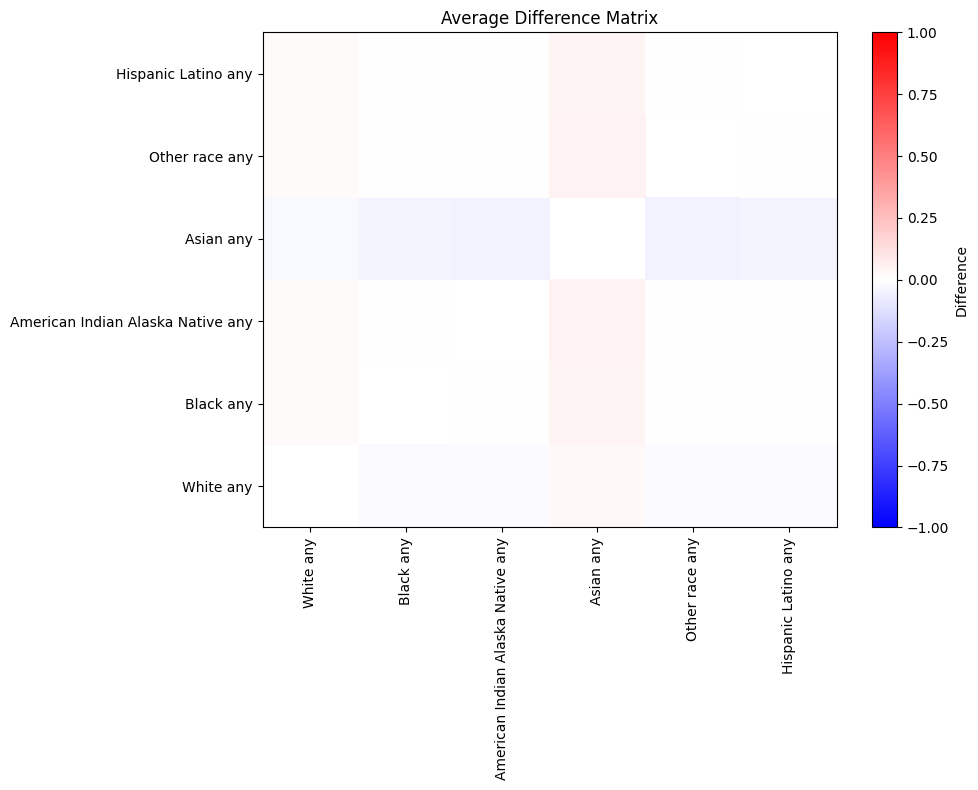

In [29]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix1 = matrix1.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap("bwr")

plt.figure(figsize=(10, 8))
plt.pcolor(matrix1, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label="Difference")
plt.xticks(
    np.arange(0.5, len(matrix1.columns), 1),
    matrix1.columns,
    rotation="vertical",
    fontsize=10,
)
plt.yticks(np.arange(0.5, len(matrix1.index), 1), matrix1.index, fontsize=10)
plt.title("Average Difference Matrix")
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()

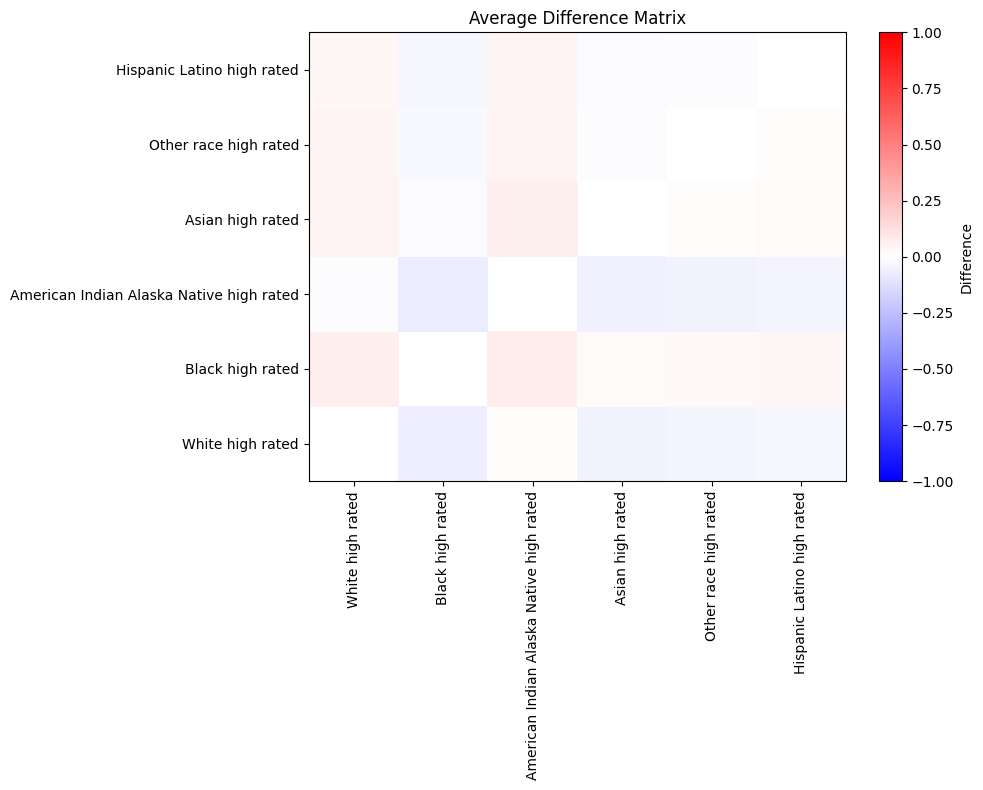

In [30]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix2 = matrix2.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap("bwr")

plt.figure(figsize=(10, 8))
plt.pcolor(matrix2, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label="Difference")
plt.xticks(
    np.arange(0.5, len(matrix2.columns), 1),
    matrix2.columns,
    rotation="vertical",
    fontsize=10,
)
plt.yticks(np.arange(0.5, len(matrix2.index), 1), matrix2.index, fontsize=10)
plt.title("Average Difference Matrix")
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()

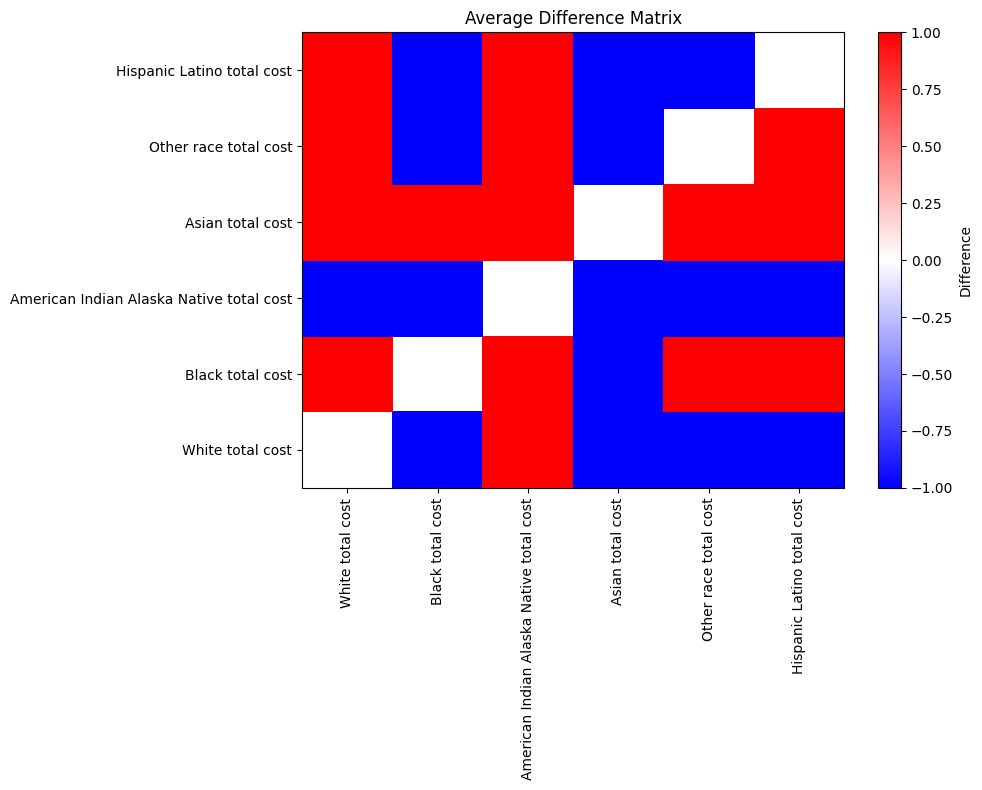

In [31]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix3 = matrix3.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap("bwr")

plt.figure(figsize=(10, 8))
plt.pcolor(matrix3, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label="Difference")
plt.xticks(
    np.arange(0.5, len(matrix3.columns), 1),
    matrix3.columns,
    rotation="vertical",
    fontsize=10,
)
plt.yticks(np.arange(0.5, len(matrix3.index), 1), matrix3.index, fontsize=10)
plt.title("Average Difference Matrix")
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()